# Import necessary libraries

In [38]:
import quandl

import pandas as pd

import numpy as np

from fbprophet import Prophet

# matplotlib pyplot for plotting
import matplotlib.pyplot as plt
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# stocker library
from stocker import Stocker

# set api key
quandl.ApiConfig.api_key = "sY8rR9LTz4kT5z2cs94v"

# Read in the data
Read the data in from the quandl api for python and then set the index to the 'date' column. We are also parsing dates in the data file.

In [39]:
# L&T Finance Holdings data
stock_ltfh_df = quandl.get('NSE/LTFH')
stock_ltfh_df = stock_ltfh_df.reset_index(level=0)

# Motherson Sumi Data
stock_mothersumi_df = quandl.get('NSE/MOTHERSUMI')
stock_mothersumi_df = stock_mothersumi_df.reset_index(level=0)

# Anantraj Ltd. Data
stock_anantraj_df = quandl.get('NSE/ANANTRAJ')
stock_anantraj_df = stock_anantraj_df.reset_index(level=0)


In [40]:
stock_ltfh_df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
1602,2018-01-31,175.00,177.65,170.50,172.40,172.60,5245741.0,9113.58
1603,2018-02-01,173.15,175.50,168.35,171.70,171.05,4187437.0,7243.73
1604,2018-02-02,169.60,169.80,154.85,156.75,157.70,9112430.0,14686.39
1605,2018-02-05,151.55,159.80,144.35,159.60,158.40,9835428.0,15192.04
1606,2018-02-06,149.00,161.65,147.55,159.60,159.35,11701257.0,18201.59


# Prepare for Prophet
For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy. The new dataframe will initially be created with an integer index so we can rename the columns

In [41]:
stock_ltfh_df = stock_ltfh_df.rename(columns={'Date':'ds', 'Close':'y'})

stock_mothersumi_df = stock_mothersumi_df.rename(columns={'Date':'ds', 'Close':'y'})

stock_anantraj_df = stock_anantraj_df.rename(columns={'Date':'ds', 'Close':'y'})

# verifying just to make sure
stock_ltfh_df.tail()

,ds,Open,High,Low,Last,y,Total Trade Quantity,Turnover (Lacs)
1602,2018-01-31,175.00,177.65,170.50,172.40,172.60,5245741.0,9113.58
1603,2018-02-01,173.15,175.50,168.35,171.70,171.05,4187437.0,7243.73
1604,2018-02-02,169.60,169.80,154.85,156.75,157.70,9112430.0,14686.39
1605,2018-02-05,151.55,159.80,144.35,159.60,158.40,9835428.0,15192.04
1606,2018-02-06,149.00,161.65,147.55,159.60,159.35,11701257.0,18201.59



Now's a good time to take a look at our data. Plotting the data using pandas' plot function

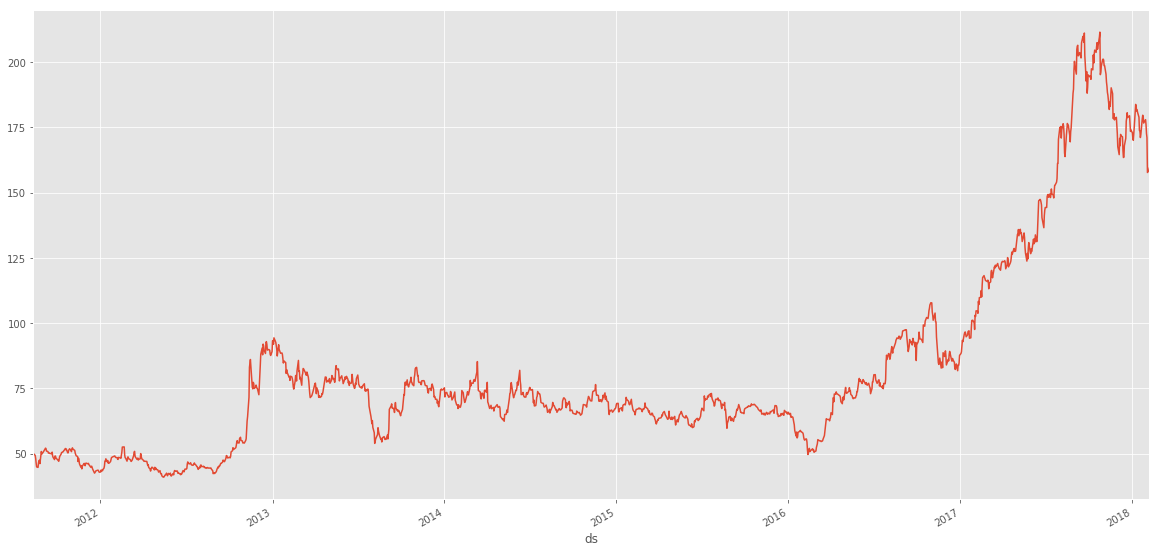

In [42]:
stock_ltfh_df.set_index('ds').y.plot()

Facebook prophet's example uses the log-transform as a way to remove some of these anomolies but it isn't the absolute 'best' way to do this...but given that its the example and a simple data series, We follow their lead for now. Taking the log of a number is easily reversible to be able to see your original data.

To log-transform your data, you can use numpy's log() function

In [43]:
stock_ltfh_df['y_orig'] = stock_ltfh_df['y']


In [44]:
stock_ltfh_df['y'] = np.log(stock_ltfh_df['y'])


In [45]:
stock_ltfh_df.tail()

,ds,Open,High,Low,Last,y,Total Trade Quantity,Turnover (Lacs),y_orig
1602,2018-01-31,175.00,177.65,170.50,172.40,5.150977,5245741.0,9113.58,172.60
1603,2018-02-01,173.15,175.50,168.35,171.70,5.141956,4187437.0,7243.73,171.05
1604,2018-02-02,169.60,169.80,154.85,156.75,5.060694,9112430.0,14686.39,157.70
1605,2018-02-05,151.55,159.80,144.35,159.60,5.065123,9835428.0,15192.04,158.40
1606,2018-02-06,149.00,161.65,147.55,159.60,5.071103,11701257.0,18201.59,159.35


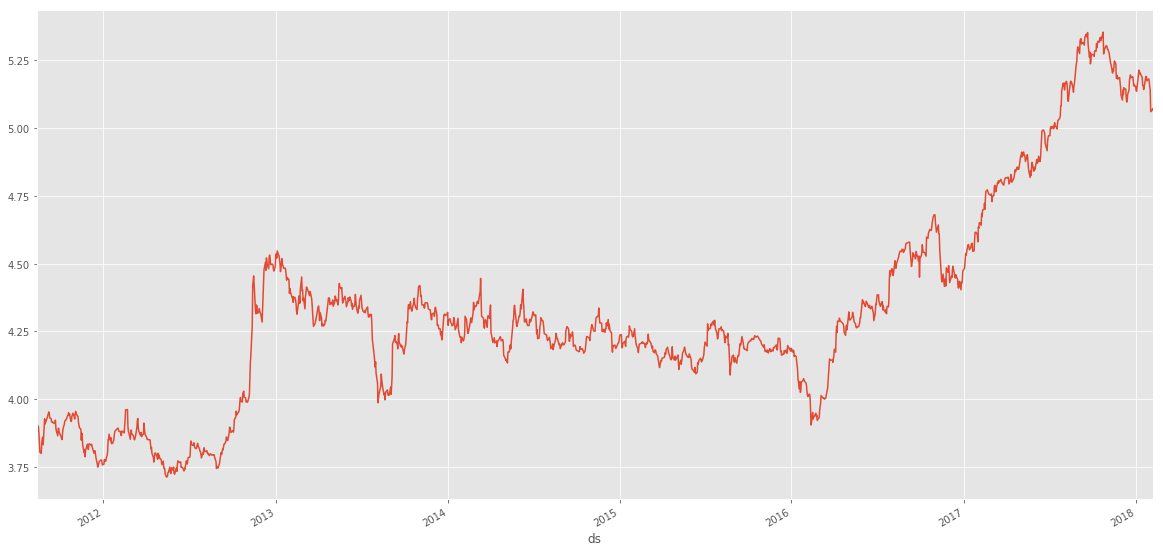

In [46]:
stock_ltfh_df.set_index('ds').y.plot()


# Running Prophet
Now, let's set prophet up to begin modeling our data.

Note: Since we are using daily data, you'll see a message from Prophet saying Disabling daily seasonality. Run prophet with daily_seasonality=True to override this. This is OK since we are working with daily data but you can disable it by using daily_seasonality=True in the instantiation of Prophet.

In [55]:
model = Prophet()

model.fit(stock_ltfh_df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting is fairly useless unless you can look into the future, so we need to add some future dates to our dataframe. For this example, I want to forecast 2 months into the future, so I'll built a future dataframe with 60 periods since we are working with daily data.

This can be done with the following code:



In [56]:
future_data = model.make_future_dataframe(periods = 60)

In [57]:
forecast_data = model.predict(future_data)
forecast_data.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
1662,2018-04-03,5.468409,5.441163,5.495037,5.325006,5.516509,-0.051725,-0.051725,-0.051725,-0.051725,-0.051725,-0.051725,-0.011179,-0.011179,-0.011179,-0.040546,-0.040546,-0.040546,5.416683
1663,2018-04-04,5.470182,5.442110,5.497664,5.321038,5.514197,-0.050898,-0.050898,-0.050898,-0.050898,-0.050898,-0.050898,-0.010812,-0.010812,-0.010812,-0.040086,-0.040086,-0.040086,5.419284
1664,2018-04-05,5.471956,5.442885,5.500344,5.327792,5.518878,-0.051441,-0.051441,-0.051441,-0.051441,-0.051441,-0.051441,-0.011896,-0.011896,-0.011896,-0.039546,-0.039546,-0.039546,5.420514
1665,2018-04-06,5.473729,5.443721,5.502945,5.326060,5.525199,-0.051479,-0.051479,-0.051479,-0.051479,-0.051479,-0.051479,-0.012545,-0.012545,-0.012545,-0.038933,-0.038933,-0.038933,5.422250
1666,2018-04-07,5.475503,5.444651,5.505650,5.329107,5.514653,-0.053896,-0.053896,-0.053896,-0.053896,-0.053896,-0.053896,-0.015637,-0.015637,-0.015637,-0.038259,-0.038259,-0.038259,5.421607


We really only want to look at yhat, yhat_lower and yhat_upper, here yhat is the forecasted value, yhat_upper and yhat_lower are the uncertainity levels(upper and lower bounds) respectively, so we can do that with:

In [58]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1662,2018-04-03,5.416683,5.325006,5.516509
1663,2018-04-04,5.419284,5.321038,5.514197
1664,2018-04-05,5.420514,5.327792,5.518878
1665,2018-04-06,5.422250,5.326060,5.525199
1666,2018-04-07,5.421607,5.329107,5.514653



# Plotting Prophet results
Prophet has a plotting mechanism called plot. This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

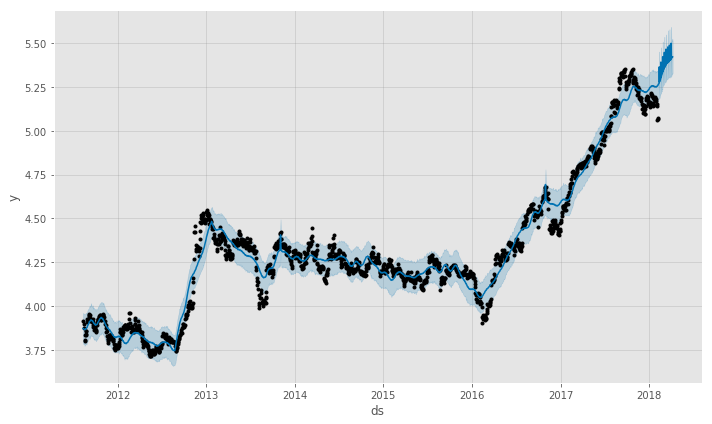

In [60]:
model.plot(forecast_data);